# Burr RAG with LanceDB and dlt document ingestion

This example shows how to build a chatbot with RAG over Substack blogs (or any RSS feed) stored into LanceDB. 

The stack includes:

- Burr
- LanceDB
- dlt
- OpenAI
- OpenTelemetry

## 1. `Substack -> LanceDB` ingestion with `dlt`

To ingest data, we use [dlt and its LanceDB integration](https://dlthub.com/devel/dlt-ecosystem/destinations/lancedb), which makes it very simple to query, embed, and store blogs from the web into LanceDB tables. 

### 1.1 Text processing

First, we define simple functions to split long text strings into sentences and a way to assemble sentences into larger context windows.

In [1]:
import re

def split_text(text):
    """Split text on punction (., !, ?)."""
    sentence_endings = r'[.!?]+'
    for sentence in re.split(sentence_endings, text):
        sentence = sentence.strip()
        if sentence:
            yield sentence


def contextualize(chunks: list[str], window=5, stride=3, min_window_size=2):
    """Rolling window operation to join consecutive sentences into larger chunks."""
    n_chunks = len(chunks)
    for start_i in range(0, n_chunks, stride):
        if (start_i + window <= n_chunks) or (n_chunks - start_i >= min_window_size):
            yield " ".join(chunks[start_i : min(start_i + window, n_chunks)])


### 1.2 Define `dlt` resources

To use `dlt`, you author `Resource` objects that generate data using the `@dlt.resource` decorator. In this case, we create a resource that pulls an RSS feed from a Substack blog URL using the `requests` and `feedparser` libraries. Then, we iterate over RSS entries and yield them as dictionaries.

In [2]:
from typing import Generator

import requests
import feedparser
import dlt

@dlt.resource(name="substack", write_disposition="merge", primary_key="id")
def rss_entries(substack_url: str) -> Generator:
    """Substack blog entries retrieved from a RSS feed"""
    FIELDS_TO_EXCLUDE = [
        "published_parsed",
        "title_detail",
        "summary_detail",
        "author_detail",
        "guidislink",
        "authors",
        "links"
    ]

    r = requests.get(f"{substack_url}/feed")
    rss_feed = feedparser.parse(r.content)
    for entry in rss_feed["entries"]:
        for field in FIELDS_TO_EXCLUDE:
            entry.pop(field)

        yield entry

You can then use `@dlt.transformer` to define operations on the values returned by `Resource` objects. In this case, we define three transformations that we'll chain:

1. Parse HTML into a string stripped of tags
2. Chunk the text string by splitting it into sentences
3. Join sentence chunks into larger "context windows" via a rolling operation.

We use a custom trick to map and store the relationship between HTML pages, sentence chunks, and context windows ([learn more]("https://github.com/dlt-hub/dlt/issues/1699")).

In [3]:
from bs4 import BeautifulSoup
import utils


@dlt.transformer(primary_key="id")
def parsed_html(rss_entry: dict):
    """Parse the HTML from the RSS entry"""
    soup = BeautifulSoup(rss_entry["content"][0]["value"], "html.parser")
    parsed_text = soup.get_text(separator=" ", strip=True)
    yield {"id": rss_entry["id"], "text": parsed_text}


@dlt.transformer(primary_key="chunk_id")
def chunks(parsed_html: dict) -> list[dict]:
    """Chunk text"""
    return [
        dict(
            document_id=parsed_html["id"],
            chunk_id=idx,
            text=text,
        )
        for idx, text in enumerate(split_text(parsed_html["text"]))
    ]

# order is important for reduce / rolling step
# default to order of the batch or specifying sorting key
@dlt.transformer(primary_key="context_id")
def contexts(chunks: list[dict]) -> Generator:
    """Assemble consecutive chunks into larger context windows"""
    # first handle the m-to-n relationship
    # set of foreign keys (i.e., "chunk_id")
    chunk_id_set = set(chunk["chunk_id"] for chunk in chunks)
    context_id = utils.hash_set(chunk_id_set)
    
    # create a table only containing the keys
    for chunk_id in chunk_id_set :
        yield dlt.mark.with_table_name(
            {"chunk_id": chunk_id, "context_id": context_id},
            "chunks_to_contexts_keys",
        ) 
    
    # main transformation logic
    for contextualized in contextualize([chunk["text"] for chunk in chunks]):
        yield dlt.mark.with_table_name(
            {"context_id": context_id, "text": contextualized},
            "contexts"
        )

### 1.3 Execute the pipeline

Before ingesting data, we need to the configuration for the `dlt` destination (LanceDB in our case). We specify which OpenAI model we want to use for text embedding and store our API key.

`dlt` provides [multiple ways to do so](https://dlthub.com/devel/general-usage/credentials), but using the `os` module is simply the most convenient for this tutorial.

In [4]:
import os

# set your OpenAI API key
openai_api_key = 

# this environment variable isn't needed by dlt, but we'll use it later
os.environ["OPENAI_API_KEY"] = openai_api_key

os.environ["DESTINATION__LANCEDB__EMBEDDING_MODEL_PROVIDER"] = "openai"
os.environ["DESTINATION__LANCEDB__EMBEDDING_MODEL"] = "text-embedding-3-small"

os.environ["DESTINATION__LANCEDB__CREDENTIALS__URI"] = ".lancedb"
os.environ["DESTINATION__LANCEDB__CREDENTIALS__EMBEDDING_MODEL_PROVIDER_API_KEY"] = openai_api_key

Next, we combine our Substack blog `Resource` with the different text processing `Transformer` using the pipe operator `|`. We also use the `lancedb_adapter` by `dlt` which allows to specify which field will be embed with the OpenAI embedding service.

In [5]:
from dlt.destinations.adapters import lancedb_adapter
import dlt.destinations.impl.lancedb.models

blog_url = "https://blog.dagworks.io/"

full_entries = lancedb_adapter(rss_entries(blog_url), embed="summary")
chunked_entries = rss_entries(blog_url) | parsed_html | chunks
contextualized_chunks = lancedb_adapter(chunked_entries | contexts, embed="text")

/home/tjean/projects/dagworks/burr/examples/rag-lancedb-ingestion/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we create the `Pipeline` object and minimally specify a `pipeline_name` and `destination`. This won't exectue any code or ingest any data.

Then, calling `pipeline.run()` with the `Resource` and `Transformer` objects will launch the ingestion job and return a `LoadInfo` object detailing the results of the job.

In [6]:
pipeline = dlt.pipeline(
    pipeline_name="substack-blog",
    destination="lancedb",
    dataset_name="dagworks"
)

In [7]:
load_info = pipeline.run([full_entries, chunked_entries, contextualized_chunks])
print(load_info)

Pipeline substack-blog load step completed in 5.06 seconds
1 load package(s) were loaded to destination LanceDB and into dataset dagworks
The LanceDB destination used <dlt.destinations.impl.lancedb.configuration.LanceDBCredentials object at 0x7f2626a4ead0> location to store data
Load package 1724874594.4636345 is LOADED and contains no failed jobs


## 2. Burr RAG with LanceDB memory
Burr allows you to define an `Application` by defining a set of actions and valid transitions between them. This approach allows to define complex agents in an easy-to-understand and debug manner. 

Burr solves many challenges to productionize agents including monitoring, storing interactions, streaming, and more, and comes with a rich open-source UI for observability.

### 2.1 Define `@action`

First, we define actions the agent can take with the `@action` decorator. The function must take a `State` object as first argument and return a `State` object. The decorator specifies which `State` fields can be read from and written to.

The next cell contains two actions:
- `retrieve_relevant_chunks()` reads from the LanceDB table `dagworks___contexts` that was generated by `dlt` and retrieves the top 4 most similar rows to the `user_query` string. It writes the search results to the `relevant_chunks` state field and appends the user input to the `chat_history` state field.
- `bot_turn()` reads the `chat_history` and the `relevant_chunks` from state, combine the text into a prompt and send a request to OpenAI. The LLM's response is appended to the `chat_history` state field.

In [8]:
import textwrap

import openai
import lancedb

from burr.core import State, action


@action(reads=[], writes=["relevant_chunks", "chat_history"])
def retrieve_relevant_chunks(
    state: State,
    user_query: str,
    lancedb_con: lancedb.DBConnection,
) -> State:
    """Search LanceDB with the user query and return the top 4 results"""
    # this is a table generated by `dlt`
    text_chunks_table = lancedb_con.open_table("dagworks___contexts")

    search_results = (
        text_chunks_table
        .search(user_query)  # this automatically embed the query does vector search
        .select(["text", "id__"])  # retrieve the `text` and `id__` columns
        .limit(4)  # get the top 4 rows
        .to_list()
    )

    return state.update(relevant_chunks=search_results).append(chat_history=user_query)


@action(reads=["chat_history", "relevant_chunks"], writes=["chat_history"])
def bot_turn(state: State, llm_client: openai.OpenAI) -> State:
    """Collect relevant chunks and produce a response to the user query"""
    user_query = state["chat_history"][-1]
    relevant_chunks = state["relevant_chunks"]

    # create system and user prompts
    system_prompt = textwrap.dedent(
        """You are a conversational agent designed to discuss and provide \
        insights about various blog posts. Your task is to engage users in \
        meaningful conversations based on the content of the blog articles they mention.
        """
    )
    joined_chunks = ' '.join([c["text"] for c in relevant_chunks])
    user_prompt = "BLOGS CONTENT\n" + joined_chunks + "\nUSER QUERY\n" + user_query

    # query the OpenAI API
    response = llm_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    bot_answer = response.choices[0].message.content

    return state.append(chat_history=bot_answer)


### 2. Assemble the `Application`
To build a Burr `Application`, you need to pass it actions and define valid transitions as tuples  `(from, to)`. The application must also define an `entrypoint` from where to begin execution. Then, we can visualize the graph of possible states and actions.

First, let's see the simplest `Application` definition.

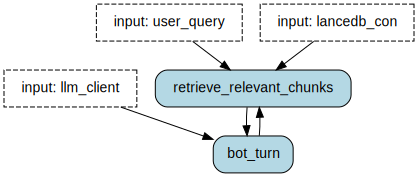

In [9]:
from burr.core import ApplicationBuilder

application = (
    ApplicationBuilder()
    .with_actions(retrieve_relevant_chunks, bot_turn)
    .with_transitions(
        ("retrieve_relevant_chunks", "bot_turn"),
        ("bot_turn", "retrieve_relevant_chunks"),
    )
    .with_entrypoint("retrieve_relevant_chunks")
    .build()
)
application.visualize()

The `ApplicationBuilder` patterns allows you to add all the features you need for production-readiness without modifying the logic of your agent. In the next few cells we'll add:

- a hook to display the bot replies
- tracking and storing execution metadata
- add OpenTelemetry support

To quickly develop an interactive experience in the terminal, we can add a `Hook` that will run after each `step` (i.e., `action`). It will check if the name of the previously completed action is equal to `bot_turn`. If it's the case, the hook prints the most recent message from the state's `chat_history`, in other words, the bot's reply.

In [10]:
from burr.lifecycle import PostRunStepHook

class PrintBotAnswer(PostRunStepHook):
    """Hook to print the bot's answer"""
    def post_run_step(self, *, state, action, **future_kwargs):
        if action.name == "bot_turn":
            print("\n🤖: ", state["chat_history"][-1])

This time, we specify via `.with_hooks()` to use the `PrintBotAnswer` hook and via `.with_tracker(..., use_otel_tracing=True)` to track execution and activate OpenTelemetry support. By importing the `opentelemetry.instrumentation` packages for `openai` and `lancedb` and using their `Instrumentor`, we'll be able to track more execution metadata.

Also, we create the `OpenAI` client and the `LanceDBConnection` and bind to specific action parameter using the `.bind()` parameter. Notice how it changes the visualization slightly.

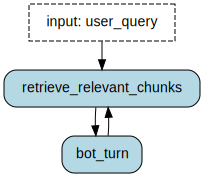

In [11]:
from burr.core import ApplicationBuilder
from opentelemetry.instrumentation.openai import OpenAIInstrumentor
from opentelemetry.instrumentation.lancedb import LanceInstrumentor

LanceInstrumentor().instrument()
OpenAIInstrumentor().instrument()

llm_client = openai.OpenAI()
lancedb_con = lancedb.connect(os.environ["DESTINATION__LANCEDB__CREDENTIALS__URI"])

application = (
    ApplicationBuilder()
    .with_actions(
        retrieve_relevant_chunks.bind(lancedb_con=lancedb_con),
        bot_turn.bind(llm_client=llm_client),
    )
    .with_transitions(
        ("retrieve_relevant_chunks", "bot_turn"),
        ("bot_turn", "retrieve_relevant_chunks"),
    )
    .with_entrypoint("retrieve_relevant_chunks")
    .with_tracker("local", project="substack-rag", use_otel_tracing=True)
    .with_hooks(PrintBotAnswer())
    .build()
)
application.visualize()

### 3. Launch the `Application`
Finally, we start the application in a `while` loop, allowing it to run until we exit by inputting `quit` or `q`. We use `application.run()` and specify to halt after the action `bot_turn` to wait for the user's input.

In [ ]:
# Launch the Burr application in a `while` loop
print("\n## Lauching RAG application ##")
user_query = input("\nAsk something or type `quit/q` to exit: ")

while True:
    if user_query.lower() in ["quit", "q"]:
        break

    _, _, _ = application.run(
        halt_after=["bot_turn"],
        inputs={"user_query": user_query},
    )
    user_query = input("\nAsk something or type `quit/q` to exit: ")